# Country Classification with SKLearn

Paccoud William - Takahashi Vincent

Import libraries


In [131]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from pycountry_convert import  country_name_to_country_alpha3
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
pio.renderers.default = 'browser'

sns.set(rc={'figure.figsize':(21,9)})

In [132]:
country_data = pd.read_csv("Country-data.csv", index_col=0)
print(country_data)
print(country_data.iloc[0,:])

                     child_mort  exports  health  imports  income  inflation  \
country                                                                        
Afghanistan                90.2     10.0    7.58     44.9    1610       9.44   
Albania                    16.6     28.0    6.55     48.6    9930       4.49   
Algeria                    27.3     38.4    4.17     31.4   12900      16.10   
Angola                    119.0     62.3    2.85     42.9    5900      22.40   
Antigua and Barbuda        10.3     45.5    6.03     58.9   19100       1.44   
...                         ...      ...     ...      ...     ...        ...   
Vanuatu                    29.2     46.6    5.25     52.7    2950       2.62   
Venezuela                  17.1     28.5    4.91     17.6   16500      45.90   
Vietnam                    23.3     72.0    6.84     80.2    4490      12.10   
Yemen                      56.3     30.0    5.18     34.4    4480      23.60   
Zambia                     83.1     37.0

On regarde les moyennes des colonnes

In [133]:
country_data.mean()

child_mort       38.270060
exports          41.108976
health            6.815689
imports          46.890215
income        17144.688623
inflation         7.781832
life_expec       70.555689
total_fer         2.947964
gdpp          12964.155689
dtype: float64

On regarde les variances des colonnes

In [134]:
country_data.var()

child_mort    1.626423e+03
exports       7.514183e+02
health        7.545116e+00
imports       5.861042e+02
income        3.716439e+08
inflation     1.117398e+02
life_expec    7.908851e+01
total_fer     2.291734e+00
gdpp          3.359414e+08
dtype: float64

            child_mort   exports    health   imports    income  inflation  life_expec  total_fer      gdpp
child_mort    1.000000 -0.318093 -0.200402 -0.127211 -0.524315   0.288276   -0.886676   0.848478 -0.483032
exports      -0.318093  1.000000 -0.114408  0.737381  0.516784  -0.107294    0.316313  -0.320011  0.418725
health       -0.200402 -0.114408  1.000000  0.095717  0.129579  -0.255376    0.210692  -0.196674  0.345966
imports      -0.127211  0.737381  0.095717  1.000000  0.122406  -0.246994    0.054391  -0.159048  0.115498
income       -0.524315  0.516784  0.129579  0.122406  1.000000  -0.147756    0.611962  -0.501840  0.895571
inflation     0.288276 -0.107294 -0.255376 -0.246994 -0.147756   1.000000   -0.239705   0.316921 -0.221631
life_expec   -0.886676  0.316313  0.210692  0.054391  0.611962  -0.239705    1.000000  -0.760875  0.600089
total_fer     0.848478 -0.320011 -0.196674 -0.159048 -0.501840   0.316921   -0.760875   1.000000 -0.454910
gdpp         -0.483032  0.418725  0.3

<Axes: >

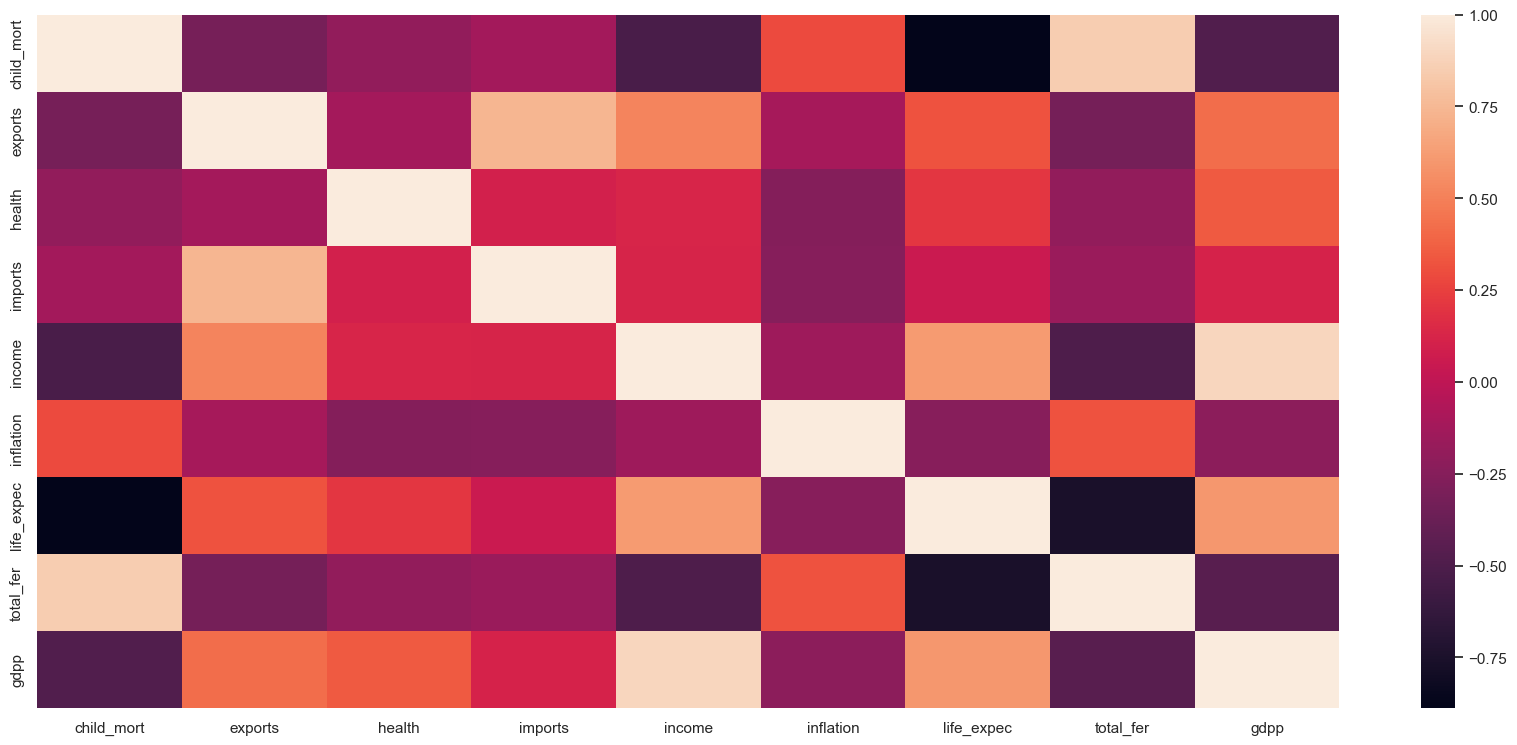

In [135]:
corr_mat = country_data.corr()
print(corr_mat.to_string())
sns.heatmap(corr_mat, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns)

On a la heatmap qui correspond a la matrice de corrélation des variables
ON cherche les variables qui sont très corrélées

- total_fer et child_mort
- income et gdpp
- imports et exports

A faire :
    
    penser a essayer combiner ces colonnes pour avoir moins de variables
    combiner les resultats

## Visualisation des données

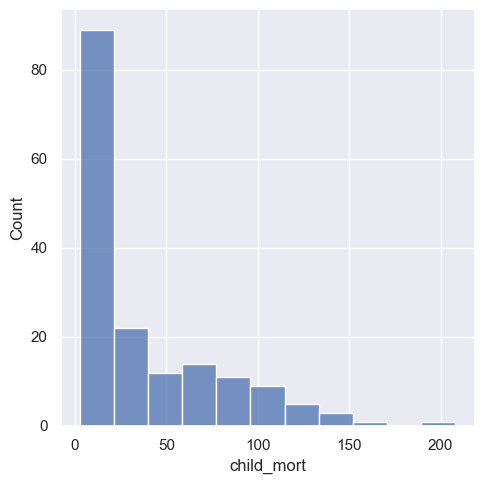

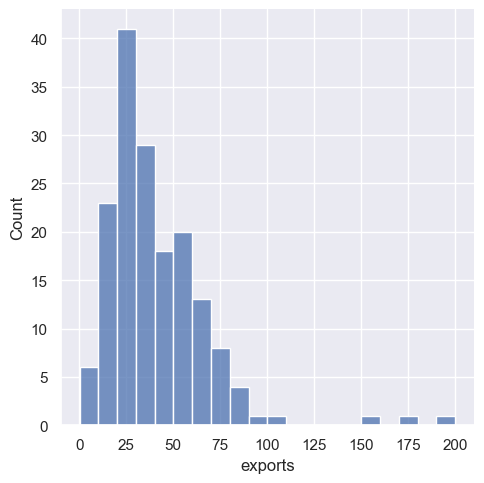

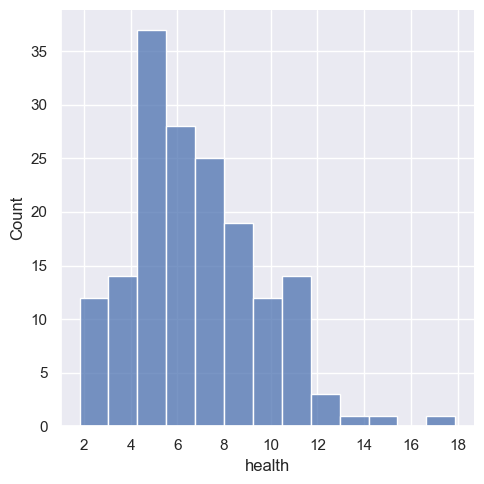

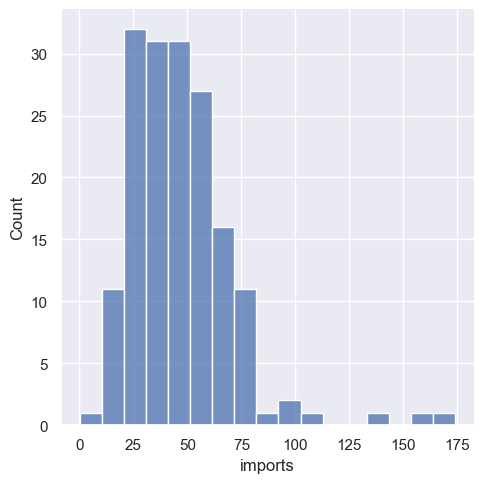

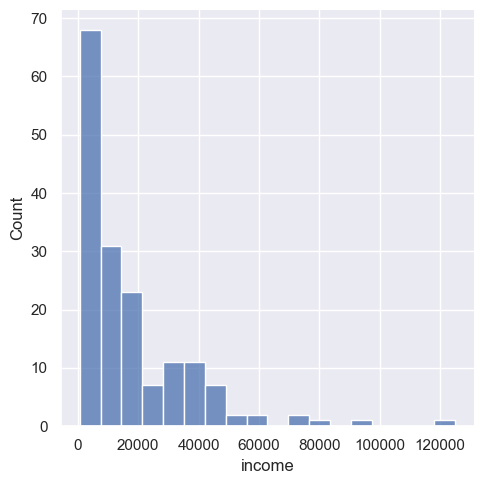

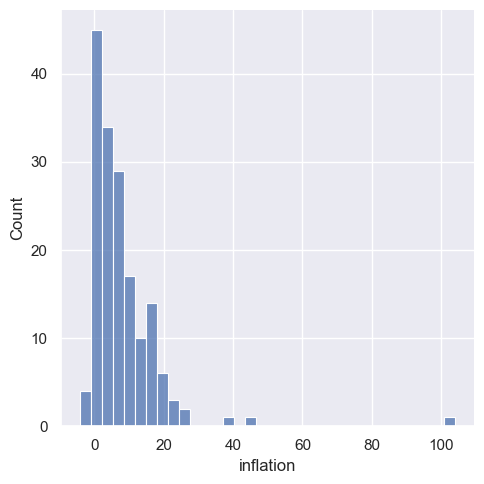

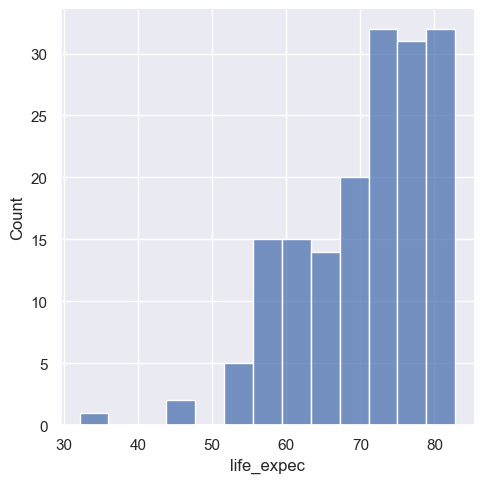

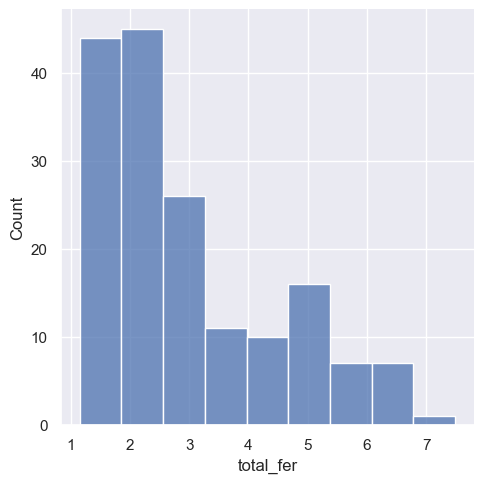

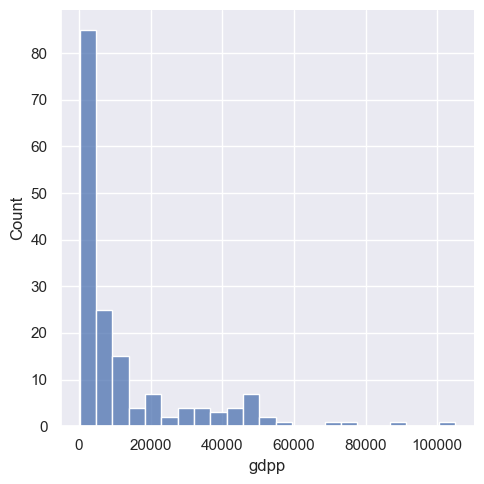

In [136]:
for i in country_data.columns.values :
    sns.displot(country_data, x=i)

La fonction ci dessous permet de récupérer les pays les plus faibles et les pays les plus forts selon le paramètre choisi

In [137]:
def extreme_country(feature, n):
    
    max_country = country_data[feature].nlargest(n)
    min_country = country_data[feature].nsmallest(n)

    return pd.concat([max_country, min_country.iloc[::-1]]).to_frame()

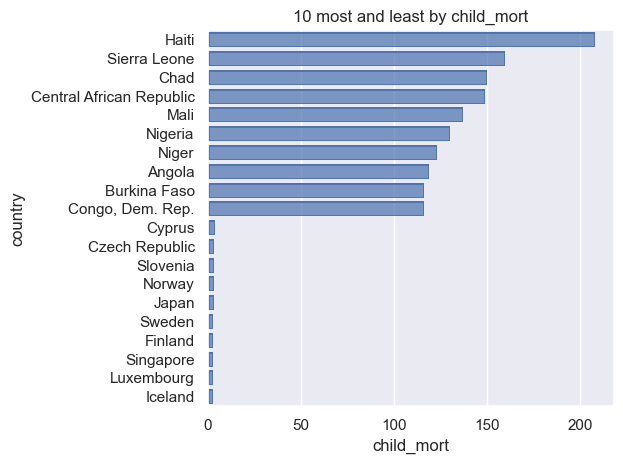

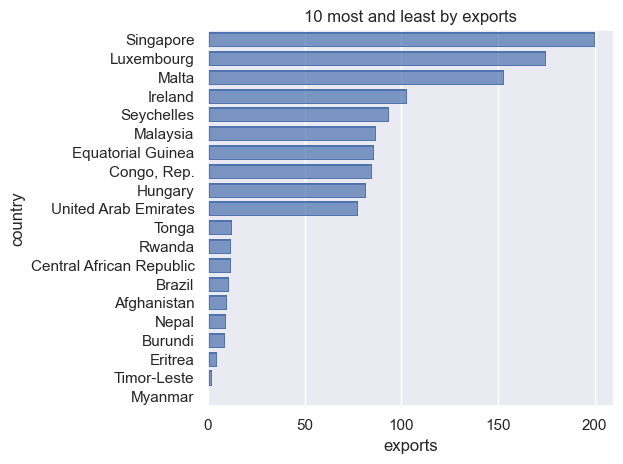

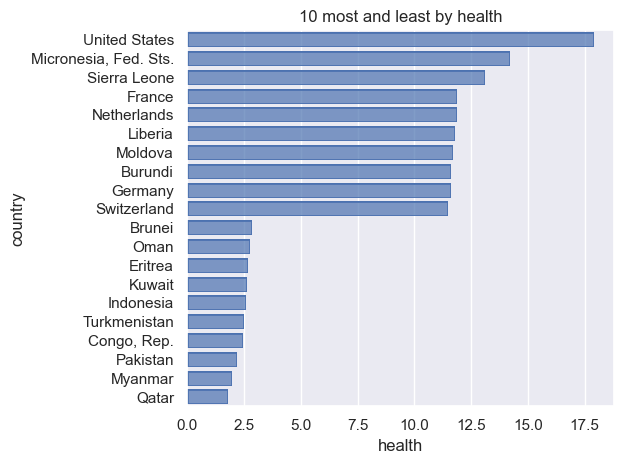

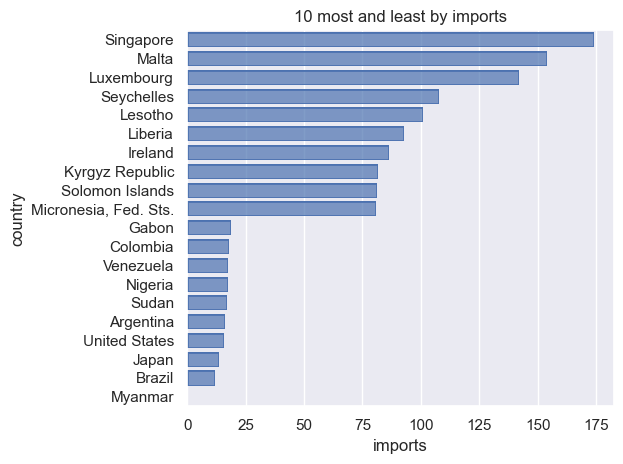

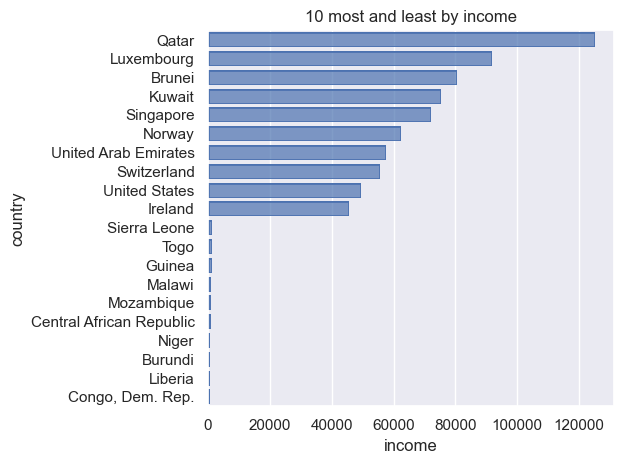

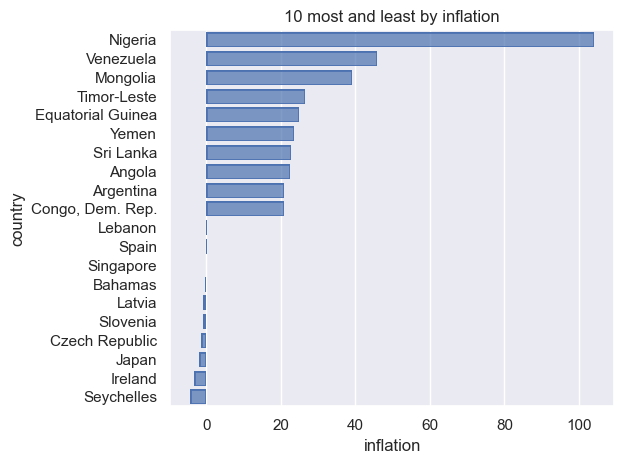

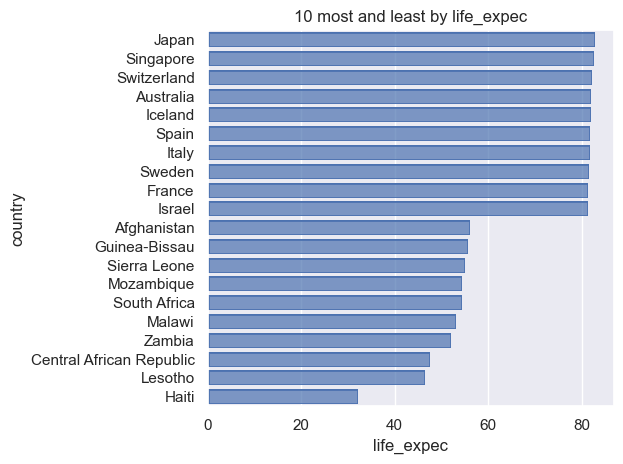

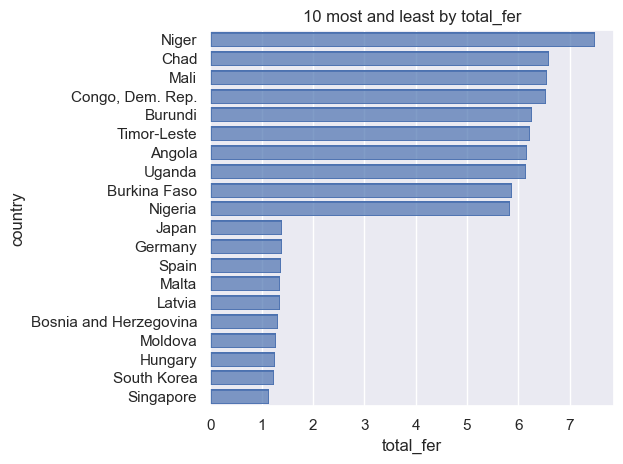

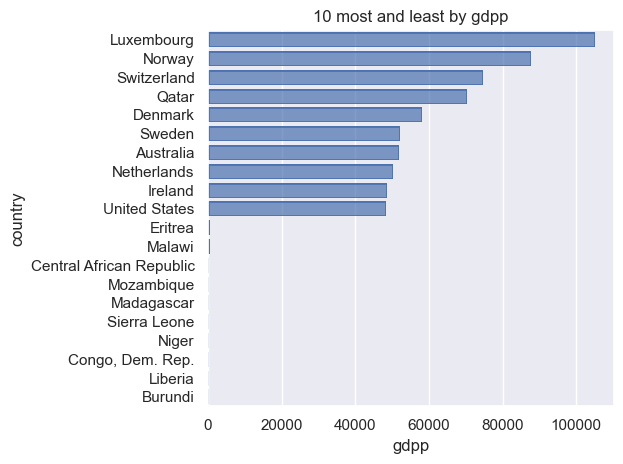

In [138]:
n = 10

for i in country_data.columns.values :
    #Pour chaque feature, on print les histogrammes mais ca fait des boites 
    df = extreme_country(i, n).reset_index()
    # sns.barplot(data = df, x='country', y=df.columns.values[0], height=7, aspect=2)
    g = so.Plot( df, y="country", x = i).add(so.Bar()).scale(aspect = 2)
    g.label(title=f"{n} most and least by {i}").show()
  

On remarque :

    Imports ne semble pas être cohérent pour notre besoin car on a des pays développés dans le top et le bas du classement.
    Export on pourait choisir de l'enlever mais on consid_re que c'ets aussi un bon indicateur économique
    

    


    Pays qui apparaissent plusieurs fois pour des motifs positifs :
     - Japon
     - Singapour 
     - Luxembourg
    
    Pays qui apparaissent plusieurs fois pour des motifs négatifs :
     - Myanmar
     - République Démocratique du Congo
     - Burundi
     - Libéria
    
A faire

    matrice de corrélation en heatmap
    si on a des valeurs qui sont très corrélées, on pourrait faire v1 + v2 /2 seulement si mm ordre de grandeur --> normaliser
    on garde l intuition et on teste

On remplace les valeurs par des valeurs que l'on normalise

In [139]:
standart_scaler = StandardScaler()
standart_country = standart_scaler.fit_transform(country_data)
standart_country

array([[ 1.29153238, -1.13827979,  0.27908825, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.47965843, -0.09701618, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.09912164, -0.96607302, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541,  1.13030491,  0.0088773 , ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.40647827, -0.59727159, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.15034774, -0.33801514, ..., -2.09278484,
         1.6246091 , -0.62954556]])

Avec la heatmap précédente, on a remarqué des corrélations entre différentes variables.
On va chercher à réduire le nombre de nos variables en combinant les colonnes pour les valeurs qui sont corrélées.


- total_fer et child_mort
- income et gdpp
- imports et exports

In [140]:
df_std_country = pd.DataFrame(standart_country, columns = country_data.columns.values)
df_std_country.index = country_data.index

df_std_country

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
country,,,,,,,,,
Afghanistan,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
Albania,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
Algeria,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
Angola,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
Antigua and Barbuda,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817
...,...,...,...,...,...,...,...,...,...
Vanuatu,-0.225578,0.200917,-0.571711,0.240700,-0.738527,-0.489784,-0.852161,0.365754,-0.546913
Venezuela,-0.526514,-0.461363,-0.695862,-1.213499,-0.033542,3.616865,0.546361,-0.316678,0.029323
Vietnam,-0.372315,1.130305,0.008877,1.380030,-0.658404,0.409732,0.286958,-0.661206,-0.637754


On combine les colonnes qui sont corrélées 2 par 2 pour éviter l'overfitting du modèle.
On a des valeurs normalisées, donc les mêmes ordres de grandeur et les colonnes auront chacune le même poids.

In [141]:
combine_col = df_std_country

combine_col['child_mort_total_fer']= (combine_col['child_mort'] + combine_col['total_fer'])/2
combine_col = combine_col.drop('child_mort', axis=1)
combine_col = combine_col.drop('total_fer',axis=1)

combine_col['income_gdpp']= (combine_col['income'] + combine_col['gdpp'])/2
combine_col = combine_col.drop('income', axis=1)
combine_col = combine_col.drop('gdpp',axis=1)

combine_col['imports_exports']= (combine_col['imports'] + combine_col['exports'])/2
combine_col = combine_col.drop('imports', axis=1)
combine_col = combine_col.drop('exports',axis=1)


combine_col

,health,inflation,life_expec,child_mort_total_fer,income_gdpp,imports_exports
country,,,,,,
Afghanistan,0.279088,0.157336,-1.619092,1.597207,-0.743713,-0.610367
Albania,-0.097016,-0.312347,0.647866,-0.699461,-0.430496,-0.204411
Algeria,-0.966073,0.789274,0.670423,-0.155619,-0.343110,-0.370442
Angola,-1.448071,1.387054,-1.179234,2.067979,-0.550656,0.305033
Antigua and Barbuda,-0.286894,-0.601749,0.704258,-0.618790,0.029957,0.329118
...,...,...,...,...,...,...
Vanuatu,-0.571711,-0.489784,-0.852161,0.070088,-0.642720,0.220809
Venezuela,-0.695862,3.616865,0.546361,-0.421596,-0.002109,-0.837431
Vietnam,0.008877,0.409732,0.286958,-0.516761,-0.648079,1.255168


On fait une ACP et on garde 2 dimensions

In [142]:
pca = PCA(n_components=2)
np_pca = pca.fit_transform(combine_col)
country_pca = pd.DataFrame(np_pca, columns = ['x','y'], index=country_data.index)

country_pca

,x,y
country,,
Afghanistan,2.189370,-1.018629
Albania,-0.540503,0.030725
Algeria,0.278663,1.137811
Angola,2.691526,1.207624
Antigua and Barbuda,-0.909111,0.245713
...,...,...
Vanuatu,0.749065,-0.067367
Venezuela,0.939555,2.346460
Vietnam,-0.300169,0.577909


<Axes: xlabel='x', ylabel='y'>

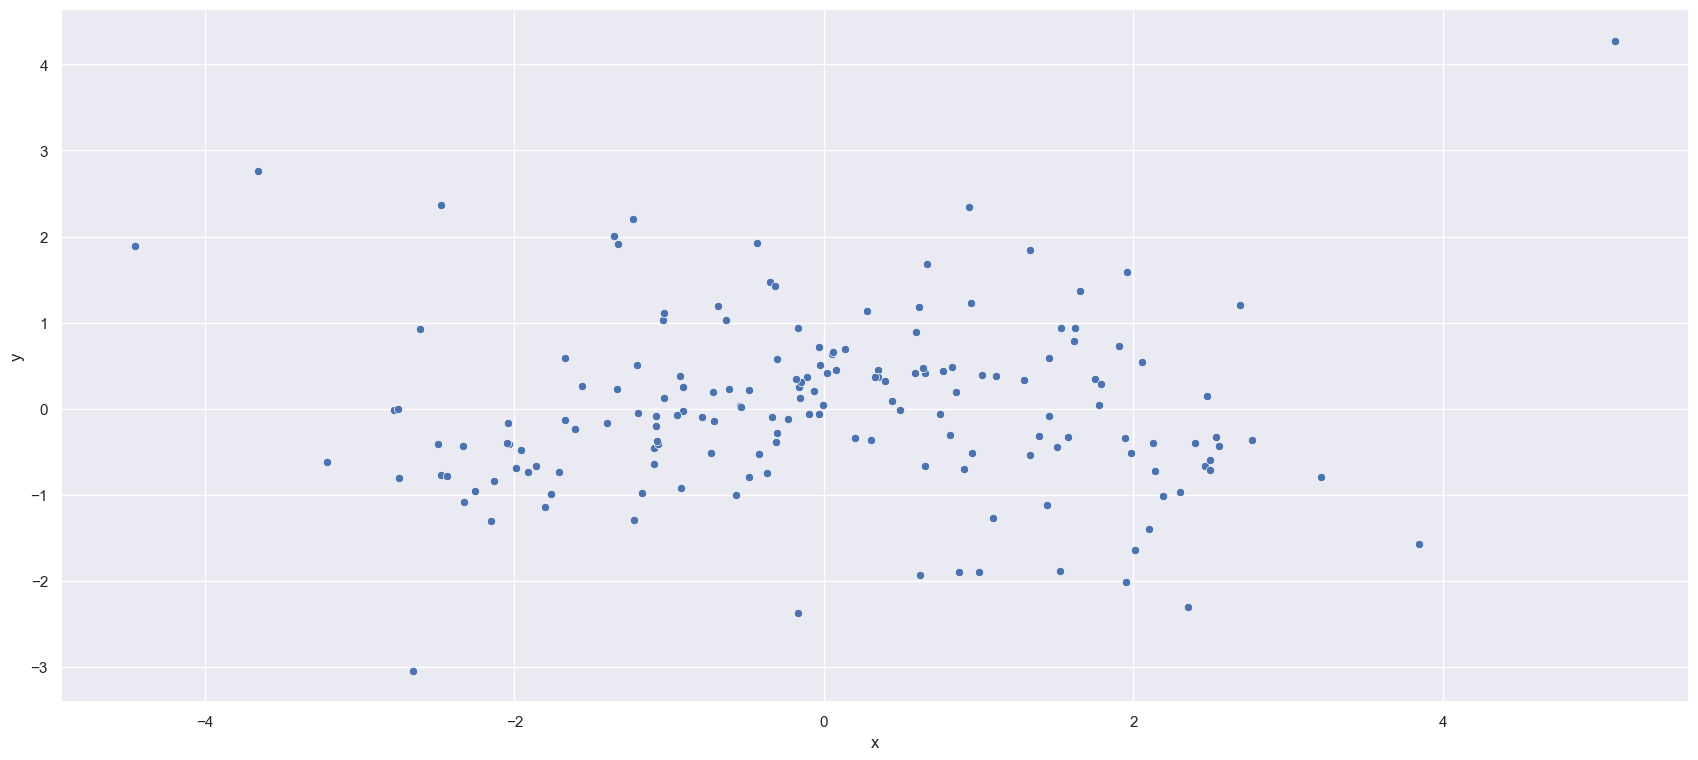

In [143]:
sns.scatterplot(data=country_pca, x='x', y='y')

On remarque en haut à droite quelques pays qui se démarquent du reste. 
Le Kmean est un algorithme sensible à ces valeurs abehrantes, on retrouvera ce problème plus tard.

<Axes: ylabel='cluster'>

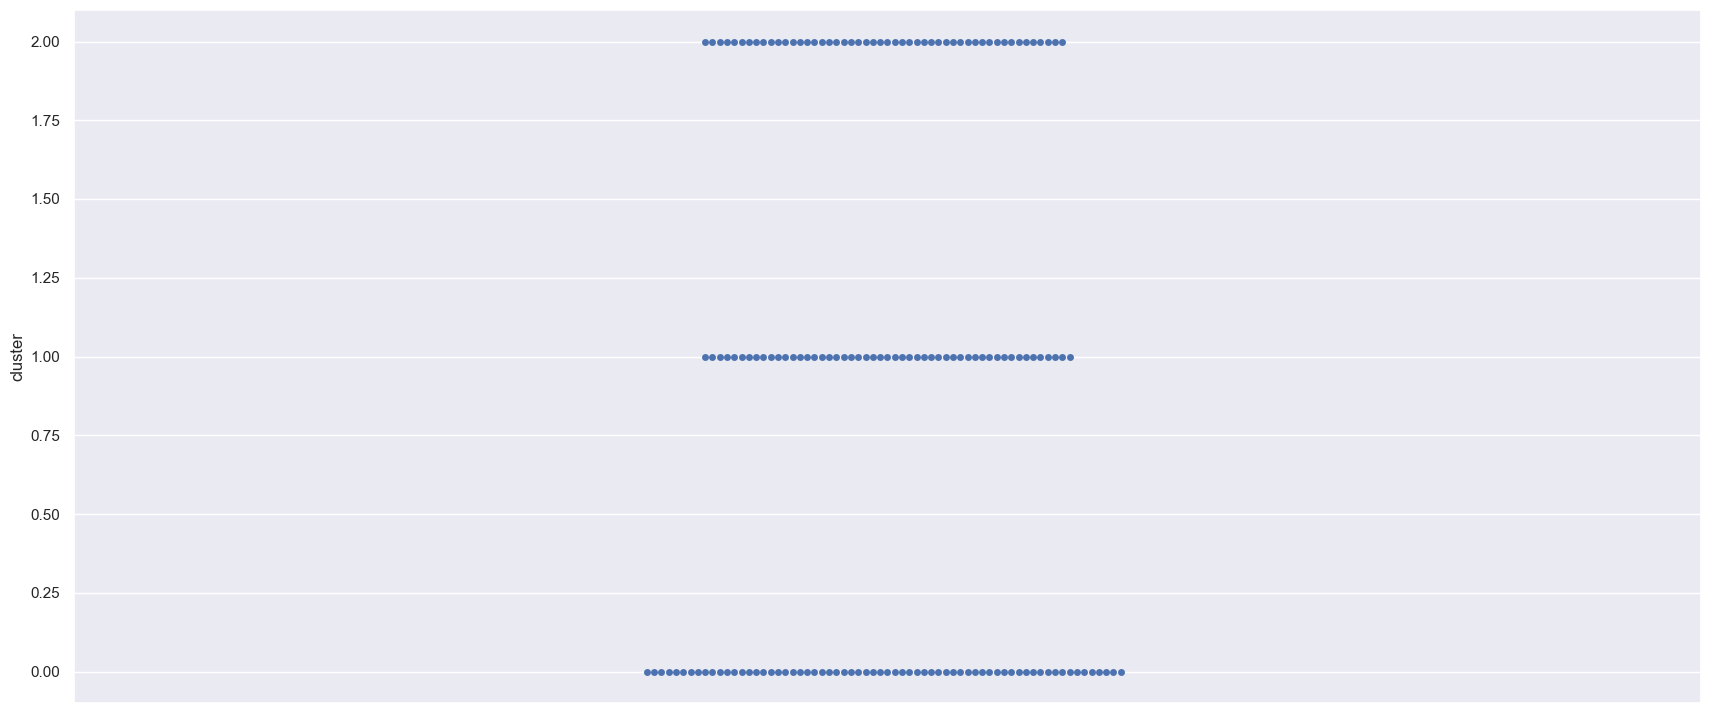

In [144]:
country_pca_kmean = country_pca.copy()
kmeans_clustering =  KMeans(n_clusters=3, random_state=0).fit(country_pca_kmean)
country_pca_kmean['cluster'] = kmeans_clustering.labels_
sns.swarmplot(data=country_pca_kmean.cluster)



In [145]:
country_pca_kmean

,x,y,cluster
country,,,
Afghanistan,2.189370,-1.018629,2
Albania,-0.540503,0.030725,0
Algeria,0.278663,1.137811,0
Angola,2.691526,1.207624,2
Antigua and Barbuda,-0.909111,0.245713,0
...,...,...,...
Vanuatu,0.749065,-0.067367,0
Venezuela,0.939555,2.346460,0
Vietnam,-0.300169,0.577909,0


<Axes: xlabel='x', ylabel='y'>

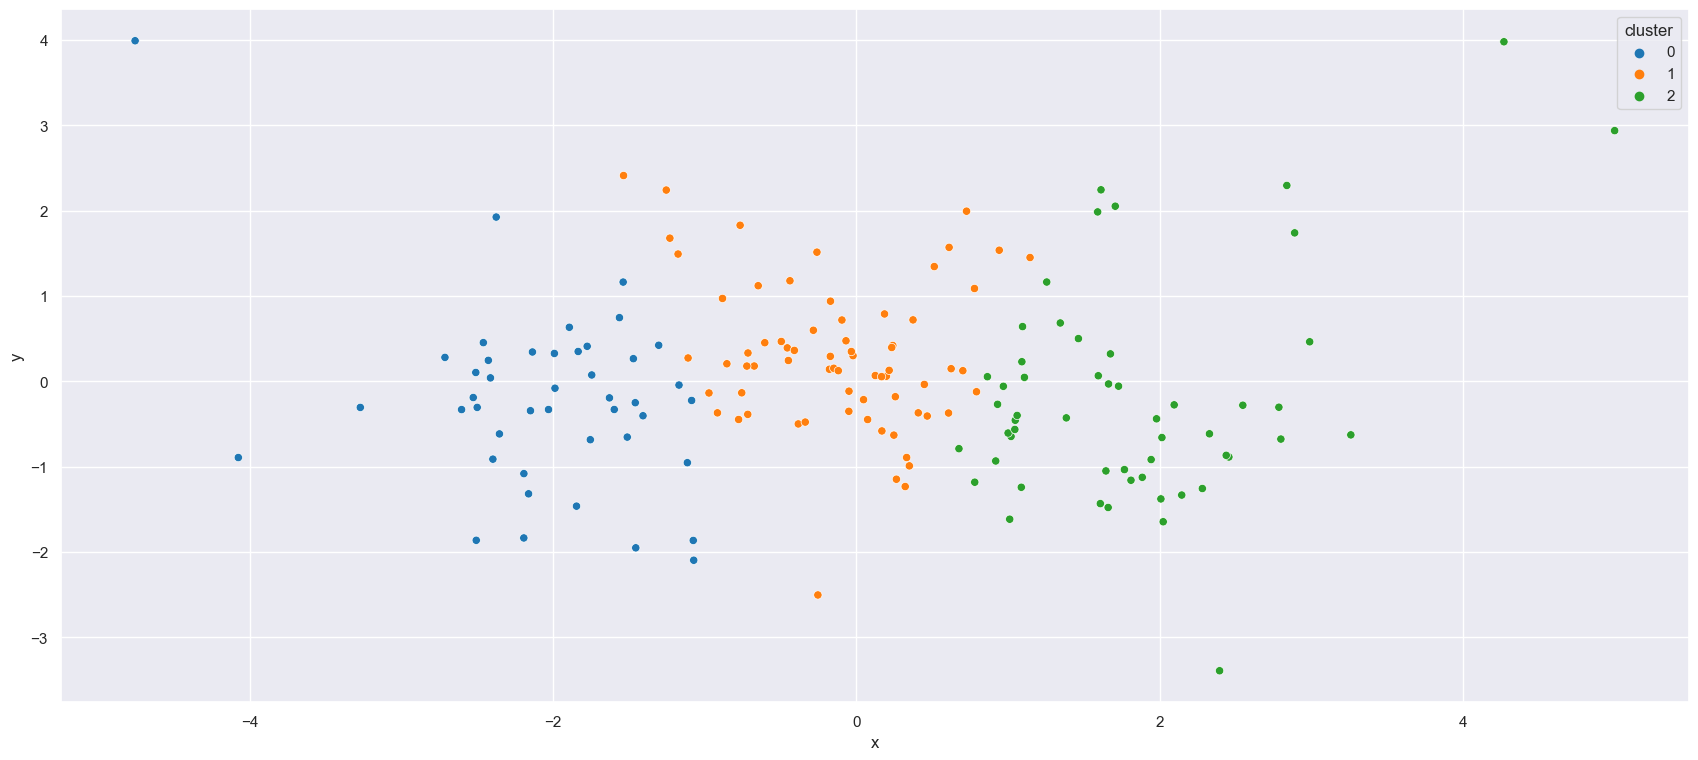

In [164]:
sns.scatterplot(data=country_pca_kmean, x='x', y='y', hue='cluster', palette="tab10")

In [147]:
metrics.silhouette_score(country_pca, kmeans_clustering.labels_, metric='euclidean')

0.36779981959259644

TEST  SELECTION FEATURES

0.334684307988293


<Axes: xlabel='x', ylabel='y'>

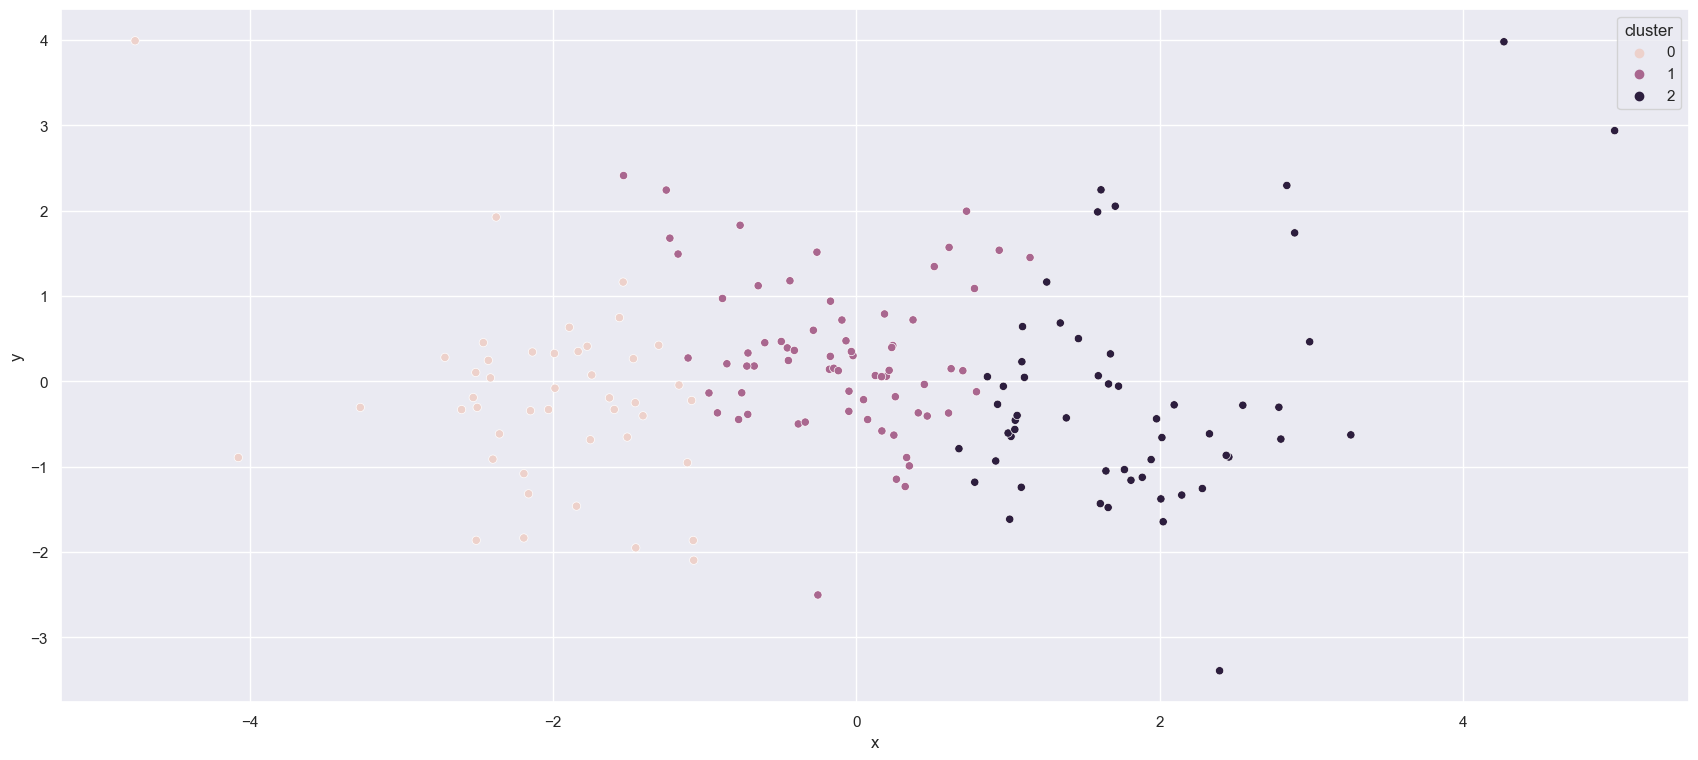

In [148]:
combine_col = df_std_country

combine_col['child_mort_total_fer']= (combine_col['child_mort'] + combine_col['total_fer'])/2
combine_col = combine_col.drop('child_mort', axis=1)
combine_col = combine_col.drop('total_fer',axis=1)

combine_col['income_gdpp']= (combine_col['income'] + combine_col['gdpp'])/2
combine_col = combine_col.drop('income', axis=1)
combine_col = combine_col.drop('gdpp',axis=1)

# On enlève imports et exports
combine_col = combine_col.drop('imports', axis=1)
# combine_col = combine_col.drop('exports',axis=1)

pca = PCA(n_components=2)
np_pca = pca.fit_transform(combine_col)
country_pca = pd.DataFrame(np_pca, columns = ['x','y'], index=country_data.index)

country_pca_kmean = country_pca.copy()
kmeans_clustering =  KMeans(n_clusters=3, random_state=0).fit(country_pca_kmean)
country_pca_kmean['cluster'] = kmeans_clustering.labels_

print(metrics.silhouette_score(country_pca, kmeans_clustering.labels_, metric='euclidean'))

sns.scatterplot(data=country_pca_kmean, x='x', y='y', hue='cluster')

On rajoute les iso des pays pour pouvoir les afficher sur la carte.

In [149]:
for i in country_pca_kmean.index:
    try:
        cn_a2_code =  country_name_to_country_alpha3(i)
    except:
        cn_a2_code = 'Unknown' 
    country_pca_kmean.at[i, 'iso'] = cn_a2_code

country_pca

,x,y
country,,
Afghanistan,-2.396968,-0.912115
Albania,0.408408,-0.369426
Algeria,-0.170532,0.938930
Angola,-2.375071,1.924894
Antigua and Barbuda,0.864288,0.054193
...,...,...
Vanuatu,-0.722117,0.178665
Venezuela,-0.766483,1.828899
Vietnam,0.373795,0.719836


In [150]:
country_pca_kmean2 = country_pca_kmean.reset_index()
country_pca_kmean2['cluster'] = country_pca_kmean2['cluster'].astype(str)
fig = px.choropleth(country_pca_kmean2, locations='iso', color='cluster')
fig.show()

## Test spectral clustering


In [151]:
country_pca

,x,y
country,,
Afghanistan,-2.396968,-0.912115
Albania,0.408408,-0.369426
Algeria,-0.170532,0.938930
Angola,-2.375071,1.924894
Antigua and Barbuda,0.864288,0.054193
...,...,...
Vanuatu,-0.722117,0.178665
Venezuela,-0.766483,1.828899
Vietnam,0.373795,0.719836


In [180]:
country_pca_spectral = country_pca.copy()
spectral_clustering = SpectralClustering(n_clusters=3, assign_labels='discretize', affinity='rbf', gamma=1, random_state=0, n_neighbors=10).fit(country_pca_spectral)
country_pca_spectral['cluster'] = spectral_clustering.labels_

Ici on pourra jouer avec le paramètre gamma ou l'affinity  

<Axes: xlabel='x', ylabel='y'>

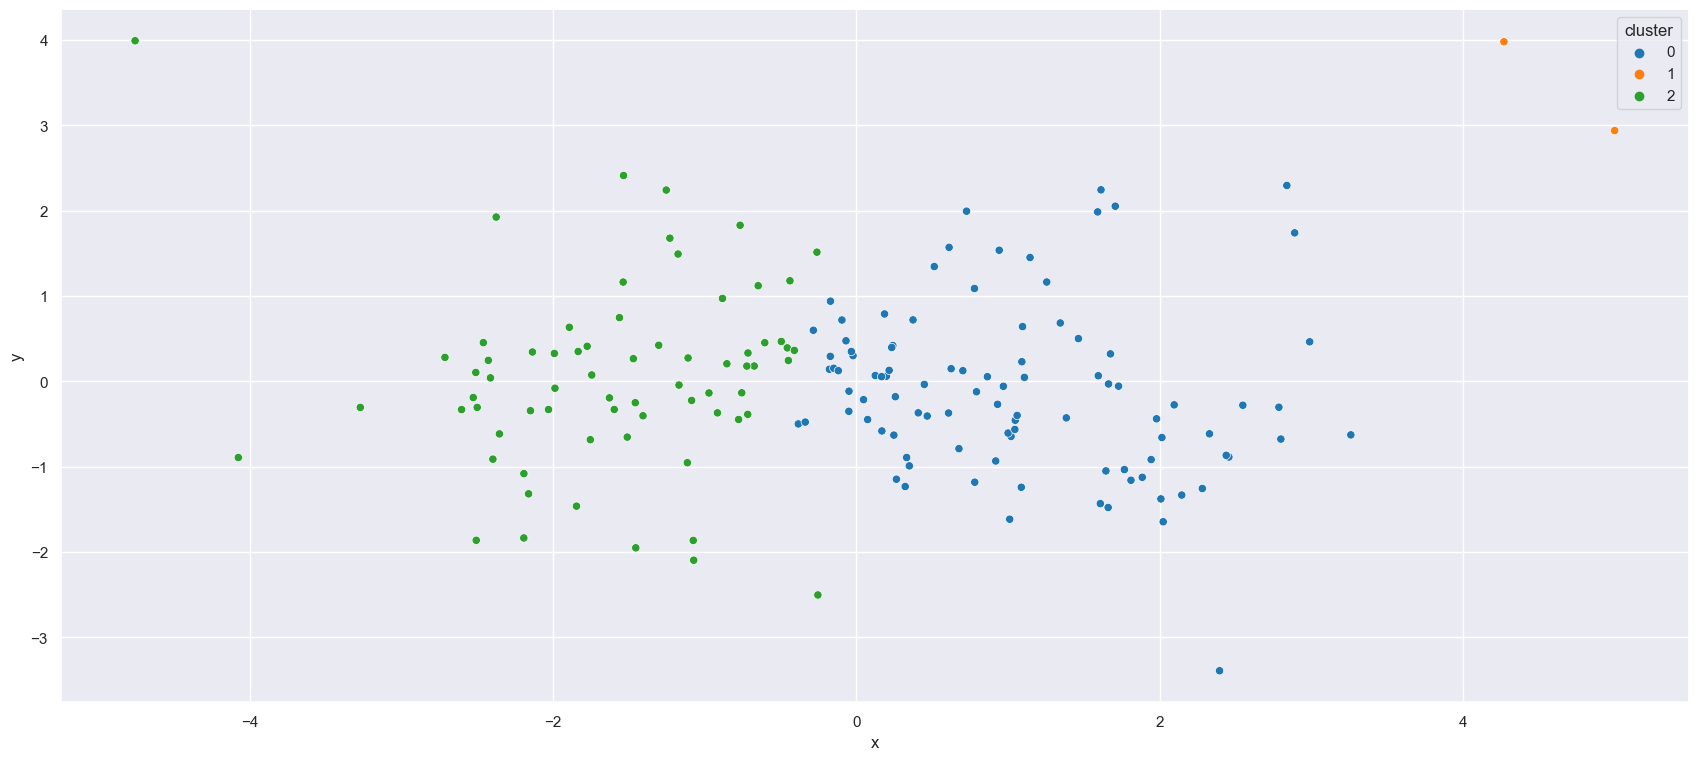

In [181]:
sns.scatterplot(data=country_pca_spectral, x='x', y='y', hue='cluster', palette="tab10")

In [182]:
for i in country_pca_spectral.index:
    try:
        cn_a2_code =  country_name_to_country_alpha3(i)
    except:
        cn_a2_code = 'Unknown' 
    country_pca_spectral.at[i, 'iso'] = cn_a2_code

country_pca_spectral

,x,y,cluster,iso
country,,,,
Afghanistan,-2.396968,-0.912115,2,AFG
Albania,0.408408,-0.369426,0,ALB
Algeria,-0.170532,0.938930,0,DZA
Angola,-2.375071,1.924894,2,AGO
Antigua and Barbuda,0.864288,0.054193,0,ATG
...,...,...,...,...
Vanuatu,-0.722117,0.178665,2,VUT
Venezuela,-0.766483,1.828899,2,VEN
Vietnam,0.373795,0.719836,0,VNM


In [183]:
country_pca_spectral2 = country_pca_spectral.reset_index()
country_pca_spectral2['cluster'] = country_pca_spectral2['cluster'].astype(str)
fig = px.choropleth(country_pca_spectral2, locations='iso', color='cluster')
fig.show()

# Test Gaussian Mixture

<Axes: xlabel='x', ylabel='y'>

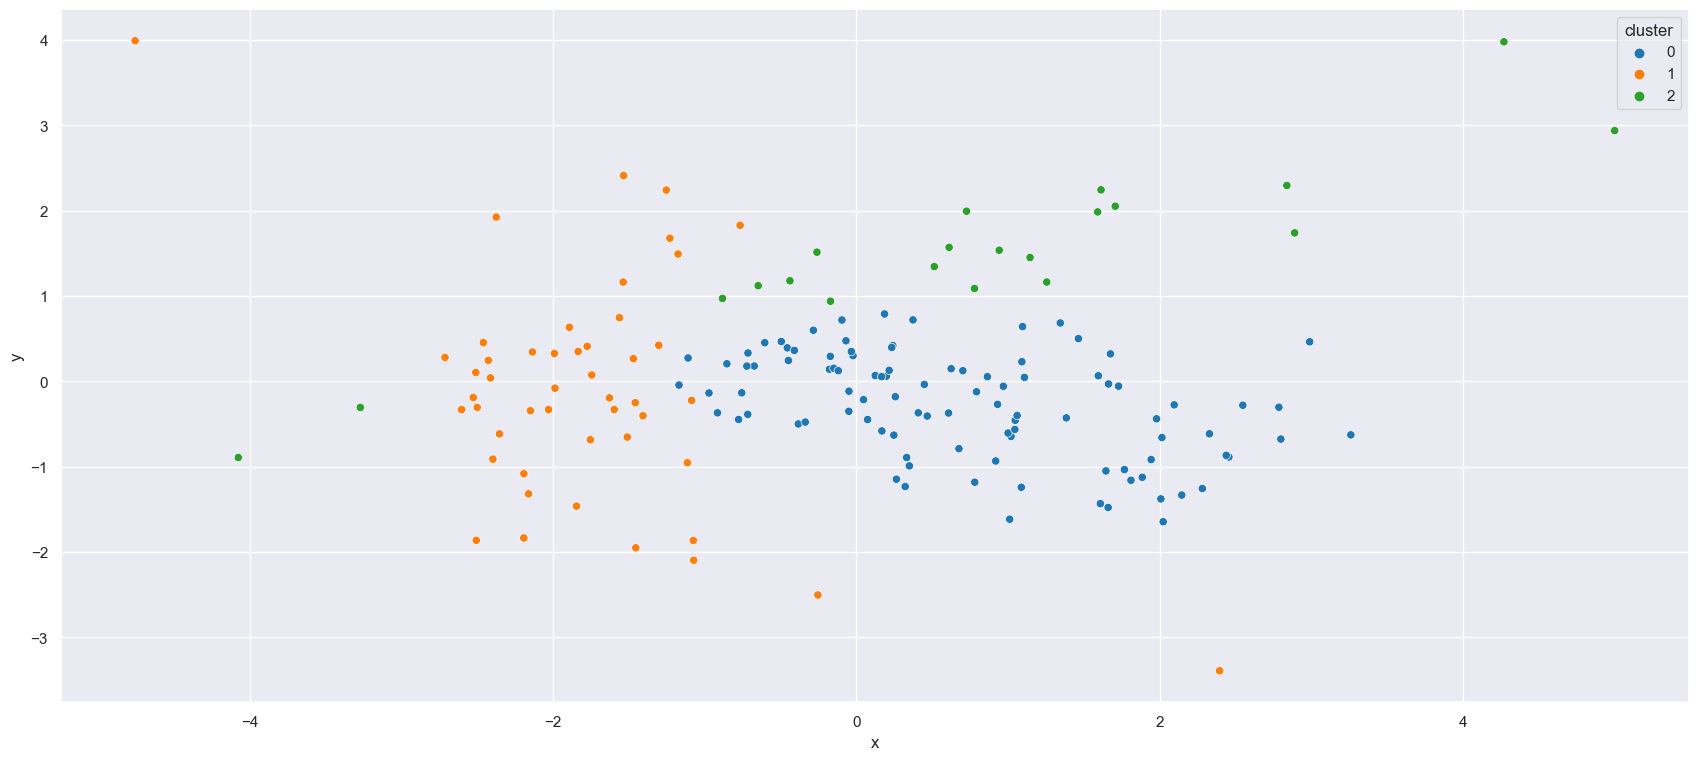

In [191]:
country_pca_gaussian = country_pca.copy()
spectral_clustering = SpectralClustering(n_clusters=3, assign_labels='discretize', affinity='rbf', random_state=0, n_neighbors=10).fit(country_pca_gaussian)


gaussian_mixture = GaussianMixture(n_components=3, random_state=123, n_init=10).fit_predict(country_pca_gaussian)


country_pca_gaussian['cluster'] = gaussian_mixture

sns.scatterplot(data=country_pca_gaussian, x='x', y='y', hue='cluster', palette="tab10")

In [192]:
for i in country_pca_gaussian.index:
    try:
        cn_a2_code =  country_name_to_country_alpha3(i)
    except:
        cn_a2_code = 'Unknown' 
    country_pca_gaussian.at[i, 'iso'] = cn_a2_code


country_pca_gaussian2 = country_pca_gaussian.reset_index()
country_pca_gaussian2['cluster'] = country_pca_gaussian2['cluster'].astype(str)
fig = px.choropleth(country_pca_gaussian2, locations='iso', color='cluster')
fig.show()

# Class observation

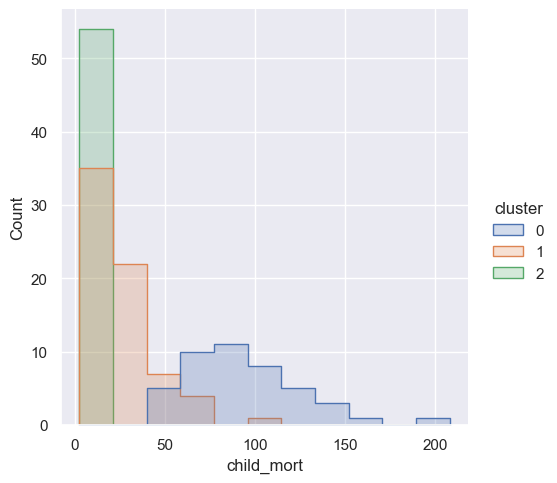

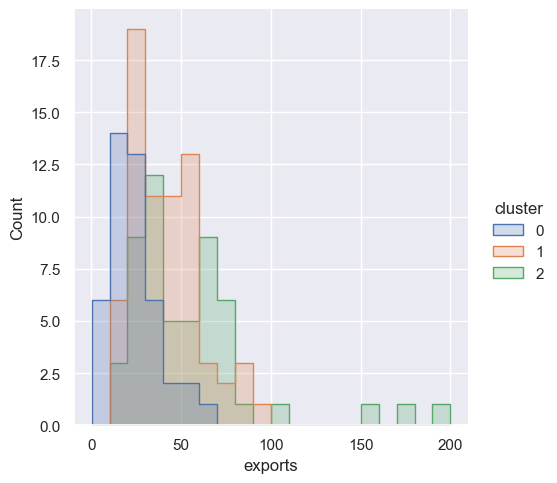

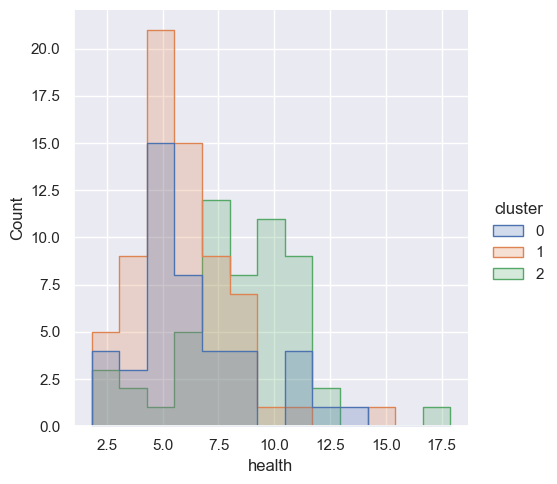

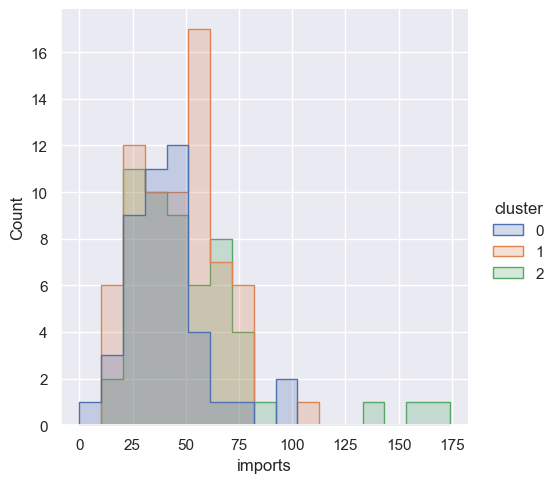

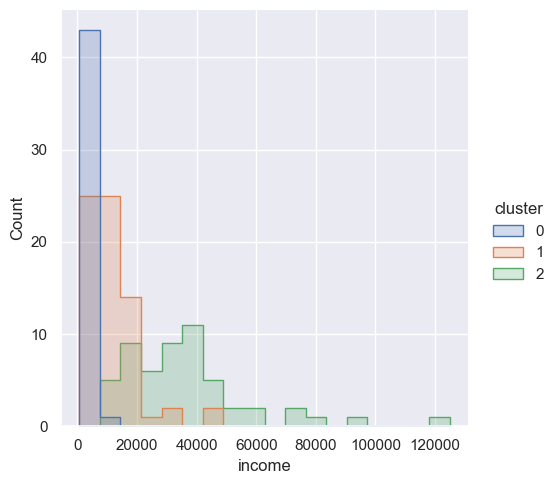

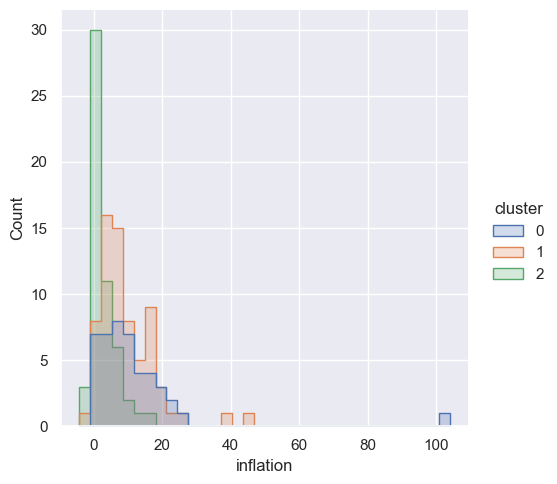

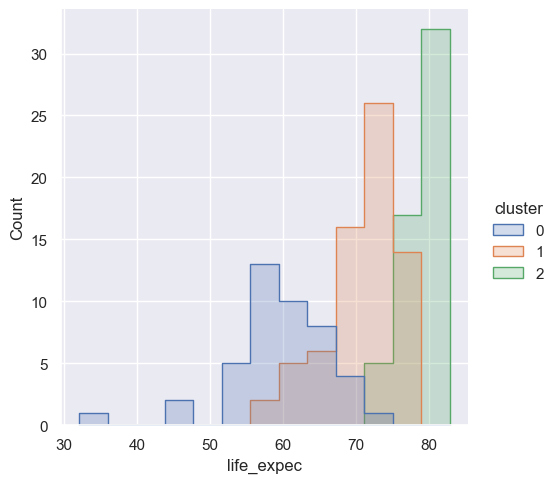

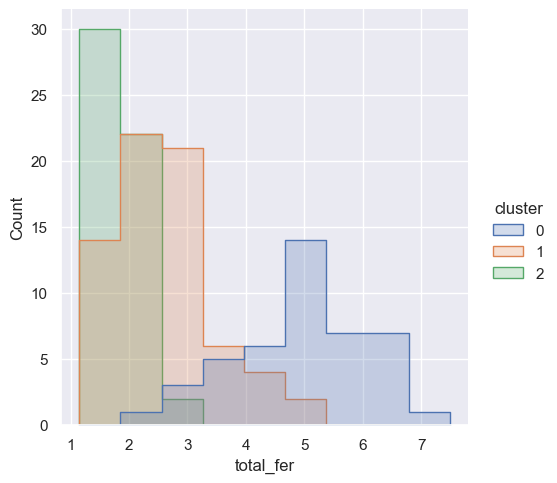

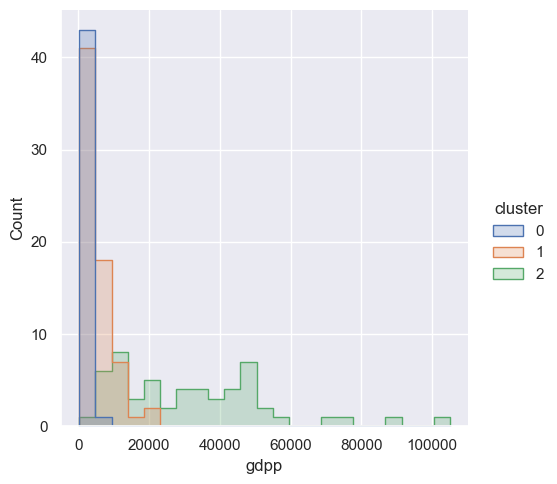

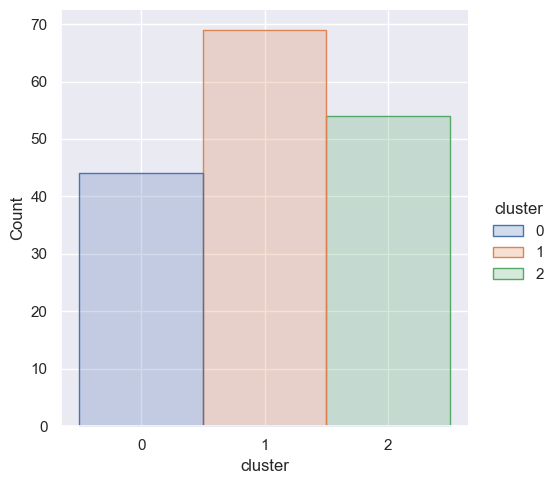

In [218]:
country_data['cluster'] = country_pca_kmean2[['country','cluster']].set_index('country')


for i in country_data.columns.values :
    sns.displot(country_data, x=i, hue="cluster", element = "step")